# Analyzing Global Access to Public Transport

*Data Source: NASA Socioeconomic Data and Applications Center (SEDAC) and Center for International Earth Science Information Network - CIESIN - Columbia University. 2023*
https://doi.org/10.7927/1a5z-3h71

Dataset Overview:
This dataset provides a comprehensive insight into the accessibility of public transport across various urban regions worldwide. This dataset could serve as a valuable resource for policymakers, urban planners, and researchers.

Objective:
The primary objective of this analysis is to understand the global disparities in public transport accessibility, identify regions with exemplary transport networks, and pinpoint areas that necessitate infrastructural development. By doing so, we aim to contribute to the global discourse on sustainable urban development and efficient public transportation systems.

Convenient access to public transport is defined as being within a 0.5-kilometer walking distance of a low-capacity public transport point or within a 1-kilometer walking distance of a high-capacity public transport point.

Low capacity transport point: bus stations in cities/highways, tram stops <br>
High capacity: Ferry terminals, railway/subway stations <br>

In [1]:
# Importing libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Set the display format to not use scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Read the shape file
transport_access_df=gpd.read_file('sdgi-11-2-1-urban-access-public-transport-2023-shp/sdgi_11_2_1_urban_access_public_transport_2023.shp')

In [4]:
# Look at the data
transport_access_df.sample(5)

,CTR_MN_ISO,CTR_MN_NM,UC_NM_MN,UC_NM_LST,Total_POP,Access_POP,SDG1121pct,Shape_Leng,Shape_Area,geometry
11176,RUS,Russia,Petrozavodsk,Petrozavodsk,187448.69,131609.02,70.21,0.80,0.01,"POLYGON ((34.29417 61.83207, 34.34216 61.83207..."
9478,MEX,Mexico,Pachuca,Pachuca,439740.48,120658.48,27.44,0.46,0.01,"POLYGON ((-98.77708 20.14425, -98.76670 20.144..."
1389,CHN,China,Guangyuan,Guangyuan,54834.94,-9999.00,-9999.00,0.17,0.00,"POLYGON ((105.89595 32.43911, 105.91812 32.439..."
11253,RUS,Russia,Engels,Engels,100768.55,35555.44,35.28,0.51,0.01,"POLYGON ((46.06452 51.51316, 46.09135 51.51316..."
334,BEN,Benin,Whydah,Whydah,49000.49,-9999.00,-9999.00,0.20,0.00,"POLYGON ((2.06333 6.38625, 2.09338 6.38625, 2...."


Column description:<br>
CTR_MN_ISO: ISO unique three-letter country code <br>
CTR_MN_NM: Country Name <br>
UC_NM_MN: Urban Center Name <br>
UC_NM_LST: List of Urban Centers in the Polygon (Shape/Geometry) <br>
Total_POP: Total population of the Urban Center <br>
Access_POP: Population who have access to public transport <br>
SDG1121pct: percentage of population who have access to public transport <br>
Shape_Leng: Length of the perimeter of the geometric shape <br>
Shape_Area: Area of the geometric shape <br>
Geometry: geometric data required for plotting <br>

In [5]:
# Number of countries in the dataset
transport_access_df['CTR_MN_NM'].nunique()

182

In [6]:
# Looking at the shape of the dataset
transport_access_df.shape

(13135, 10)

In [7]:
# Checking for duplicates
transport_access_df['geometry'].nunique()

13135

### Data Cleaning

Handling missing data:

Decision:
* Not to Impute: Avoiding assumptions about public transport access
* Not to Drop: Retaining all records for completeness

Reasoning:
* Imputing could lead to misrepresentation, as we cannot accurately predict public transport access for these urban centers.
* Retaining all records ensures a complete dataset

Impact:
* Map Visualization: Null values in Access_POP and Total_POP will not impact the geometric representation on the map.
* Country-Level Aggregation: For analyses that require aggregating population and access data at a country level, records with a known population but no access information could skew the results. In such cases, it may be prudent to exclude these records from the aggregation to ensure accuracy. So at a later point in this code, we will be dropping those records while aggregating to a country level.

Data cleaning steps:
* Replace -9999, '-' and N/A values with NaN
* Check if there are any ivalid geomtry values
* Ensure all the columns are of appropriate data type

In [8]:
# Looking at the number of urban centers with null population
null_population=transport_access_df[transport_access_df['Total_POP']==-9999].count()
null_population['Total_POP']

20

In [9]:
# Looking at the number of urban centers with null access
null_access=transport_access_df[transport_access_df['Access_POP']==-9999].count()
null_access

CTR_MN_ISO    7386
CTR_MN_NM     7386
UC_NM_MN      7386
UC_NM_LST     7386
Total_POP     7386
Access_POP    7386
SDG1121pct    7386
Shape_Leng    7386
Shape_Area    7386
geometry      7386
dtype: int64

In [10]:
# Replace -9999 values with NaN
cleaned_transport_access=transport_access_df.replace(-9999.0, np.nan)

# Replace N/A with NaN in the string columns
cleaned_transport_access.replace(['N/A','-'], np.nan, inplace=True)

In [11]:
# Checking if all the null values have been replaced, and if the data types are correct
cleaned_transport_access.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CTR_MN_ISO  13135 non-null  object  
 1   CTR_MN_NM   13135 non-null  object  
 2   UC_NM_MN    12262 non-null  object  
 3   UC_NM_LST   12223 non-null  object  
 4   Total_POP   13115 non-null  float64 
 5   Access_POP  5749 non-null   float64 
 6   SDG1121pct  5749 non-null   float64 
 7   Shape_Leng  13135 non-null  float64 
 8   Shape_Area  13135 non-null  float64 
 9   geometry    13135 non-null  geometry
dtypes: float64(5), geometry(1), object(4)
memory usage: 1.0+ MB


In [12]:
# Look at the first 5 rows of the cleaned dataset
cleaned_transport_access.head()

,CTR_MN_ISO,CTR_MN_NM,UC_NM_MN,UC_NM_LST,Total_POP,Access_POP,SDG1121pct,Shape_Leng,Shape_Area,geometry
0,AFG,Afghanistan,NaN,NaN,2735.46,NaN,NaN,0.13,0.00,"POLYGON ((60.99316 34.71907, 61.00443 34.71907..."
1,AFG,Afghanistan,Ghurian,Ghurian,929.48,NaN,NaN,0.11,0.00,"POLYGON ((61.48939 34.35342, 61.52311 34.35342..."
2,AFG,Afghanistan,NaN,NaN,96.64,NaN,NaN,0.06,0.00,"POLYGON ((61.77517 34.94572, 61.78645 34.94572..."
3,AFG,Afghanistan,Toraghundi,Toraghundi,14976.74,NaN,NaN,0.15,0.00,"POLYGON ((62.27459 35.25994, 62.29721 35.25994..."
4,AFG,Afghanistan,Herat,Herat,317854.24,NaN,NaN,0.52,0.01,"POLYGON ((62.16848 34.38822, 62.19096 34.38822..."


In [13]:
# descriptive stats
cleaned_transport_access.describe()

,Total_POP,Access_POP,SDG1121pct,Shape_Leng,Shape_Area
count,13115.00,5749.00,5749.00,13135.00,13135.00
mean,206315.75,175364.26,35.71,0.35,0.00
std,1130822.76,993068.76,30.53,0.52,0.02
min,3.10,32.63,0.04,0.04,0.00
25%,15492.29,6840.67,10.58,0.14,0.00
50%,47924.52,19936.71,24.86,0.23,0.00
75%,111011.86,67214.12,55.25,0.38,0.00
max,45546814.39,29782363.85,100.00,14.13,0.58


In [14]:
# Look at the geometry type of the shape file
cleaned_transport_access['geometry'].type.unique()

array(['Polygon'], dtype=object)

In [15]:
# Identifying the rows with invalid geometries
invalid_geometries = cleaned_transport_access[~cleaned_transport_access.is_valid]

# Looking at the rows with invalid geometries
invalid_geometries


,CTR_MN_ISO,CTR_MN_NM,UC_NM_MN,UC_NM_LST,Total_POP,Access_POP,SDG1121pct,Shape_Leng,Shape_Area,geometry
2167,CHN,China,Zibo,Zibo; 博山区; 淄川区; 张店区,1724232.79,141590.45,8.21,2.65,0.05,"POLYGON ((118.08208 36.91728, 118.10501 36.917..."
2888,CHN,China,Shanghai,Shanghai; Fengxian; Pudong; Baoshan; Changning...,29036552.73,18342341.63,63.17,5.91,0.31,"POLYGON ((121.10593 31.50063, 121.13897 31.500..."
9064,JPN,Japan,Takasaki [Maebashi],Takasaki; Maebashi; Ota; Isesaki; Ashikaga; Ki...,1217967.61,587687.75,48.25,3.32,0.06,"POLYGON ((139.26918 36.44241, 139.28060 36.442..."


In [16]:
# Applying a small buffer to fix the invalid geometries
cleaned_transport_access["geometry"] = cleaned_transport_access.buffer(0)

# Verifying if the fix was successful
invalid_geometries_after_fix = cleaned_transport_access[~cleaned_transport_access.is_valid]

# Showing the number of invalid geometries after the fix
num_invalid_geometries_after_fix = len(invalid_geometries_after_fix)
num_invalid_geometries_after_fix


0

/var/folders/25/07yfn18x4q321sxsdsxs39wc0000gn/T/ipykernel_29169/1554683252.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cleaned_transport_access['centroid'] = cleaned_transport_access.geometry.centroid
/var/folders/25/07yfn18x4q321sxsdsxs39wc0000gn/T/ipykernel_29169/1554683252.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cleaned_transport_access['longitude'] = cleaned_transport_access.centroid.x
/var/folders/25/07yfn18x4q321sxsdsxs39wc0000gn/T/ipykernel_29169/1554683252.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cleaned_transport_access['latitude'

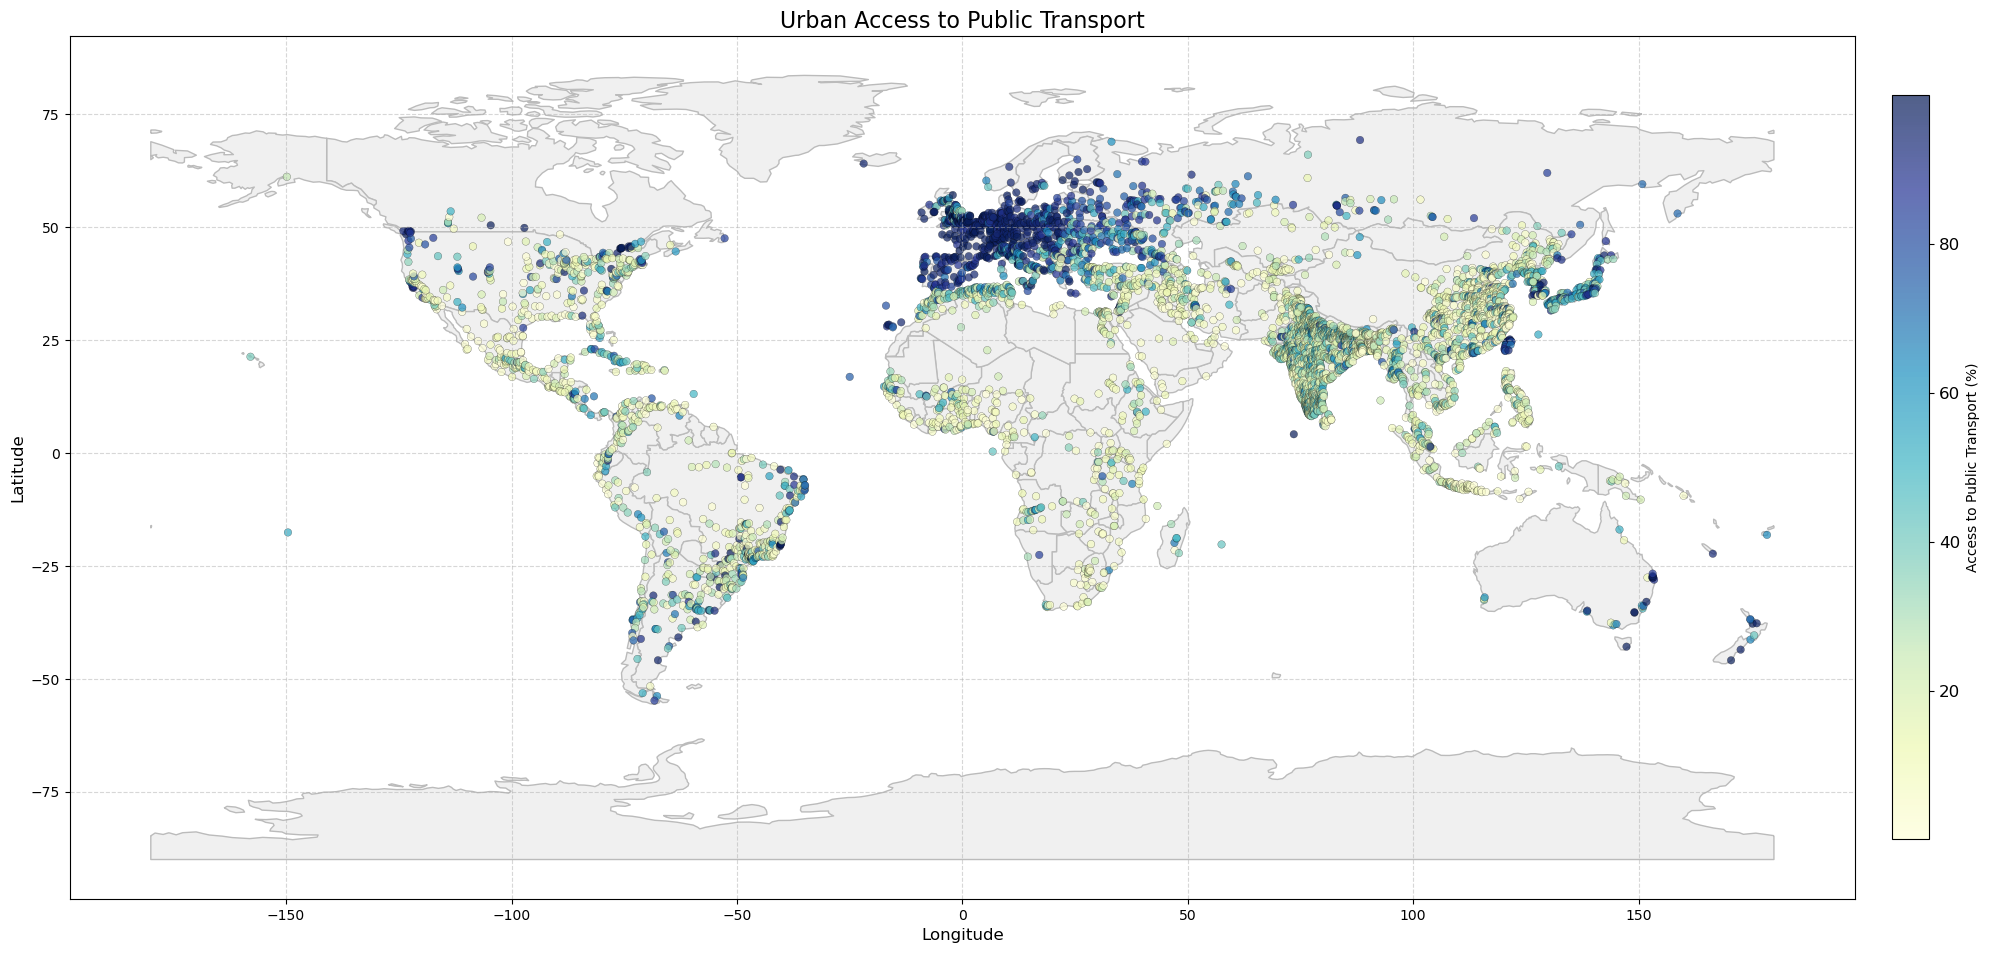

In [17]:
# Calculate centroids of the geometries for point representation
cleaned_transport_access['centroid'] = cleaned_transport_access.geometry.centroid

# Extract longitude and latitude from the centroids
cleaned_transport_access['longitude'] = cleaned_transport_access.centroid.x
cleaned_transport_access['latitude'] = cleaned_transport_access.centroid.y

# Load a world map for context
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
base = world.plot(ax=ax, color='#f0f0f0', edgecolor='#bbbbbb')  # Adjusted colors for better contrast
sc = plt.scatter(cleaned_transport_access['longitude'], cleaned_transport_access['latitude'], 
                 c=cleaned_transport_access['SDG1121pct'], cmap='YlGnBu', alpha=0.7, s=30, edgecolors='k', linewidth=0.2)  # Adjusted size, alpha, and added edge

cbar = plt.colorbar(sc, label='Access to Public Transport (%)', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=12)

plt.title('Urban Access to Public Transport', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


/var/folders/25/07yfn18x4q321sxsdsxs39wc0000gn/T/ipykernel_29169/2471935465.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


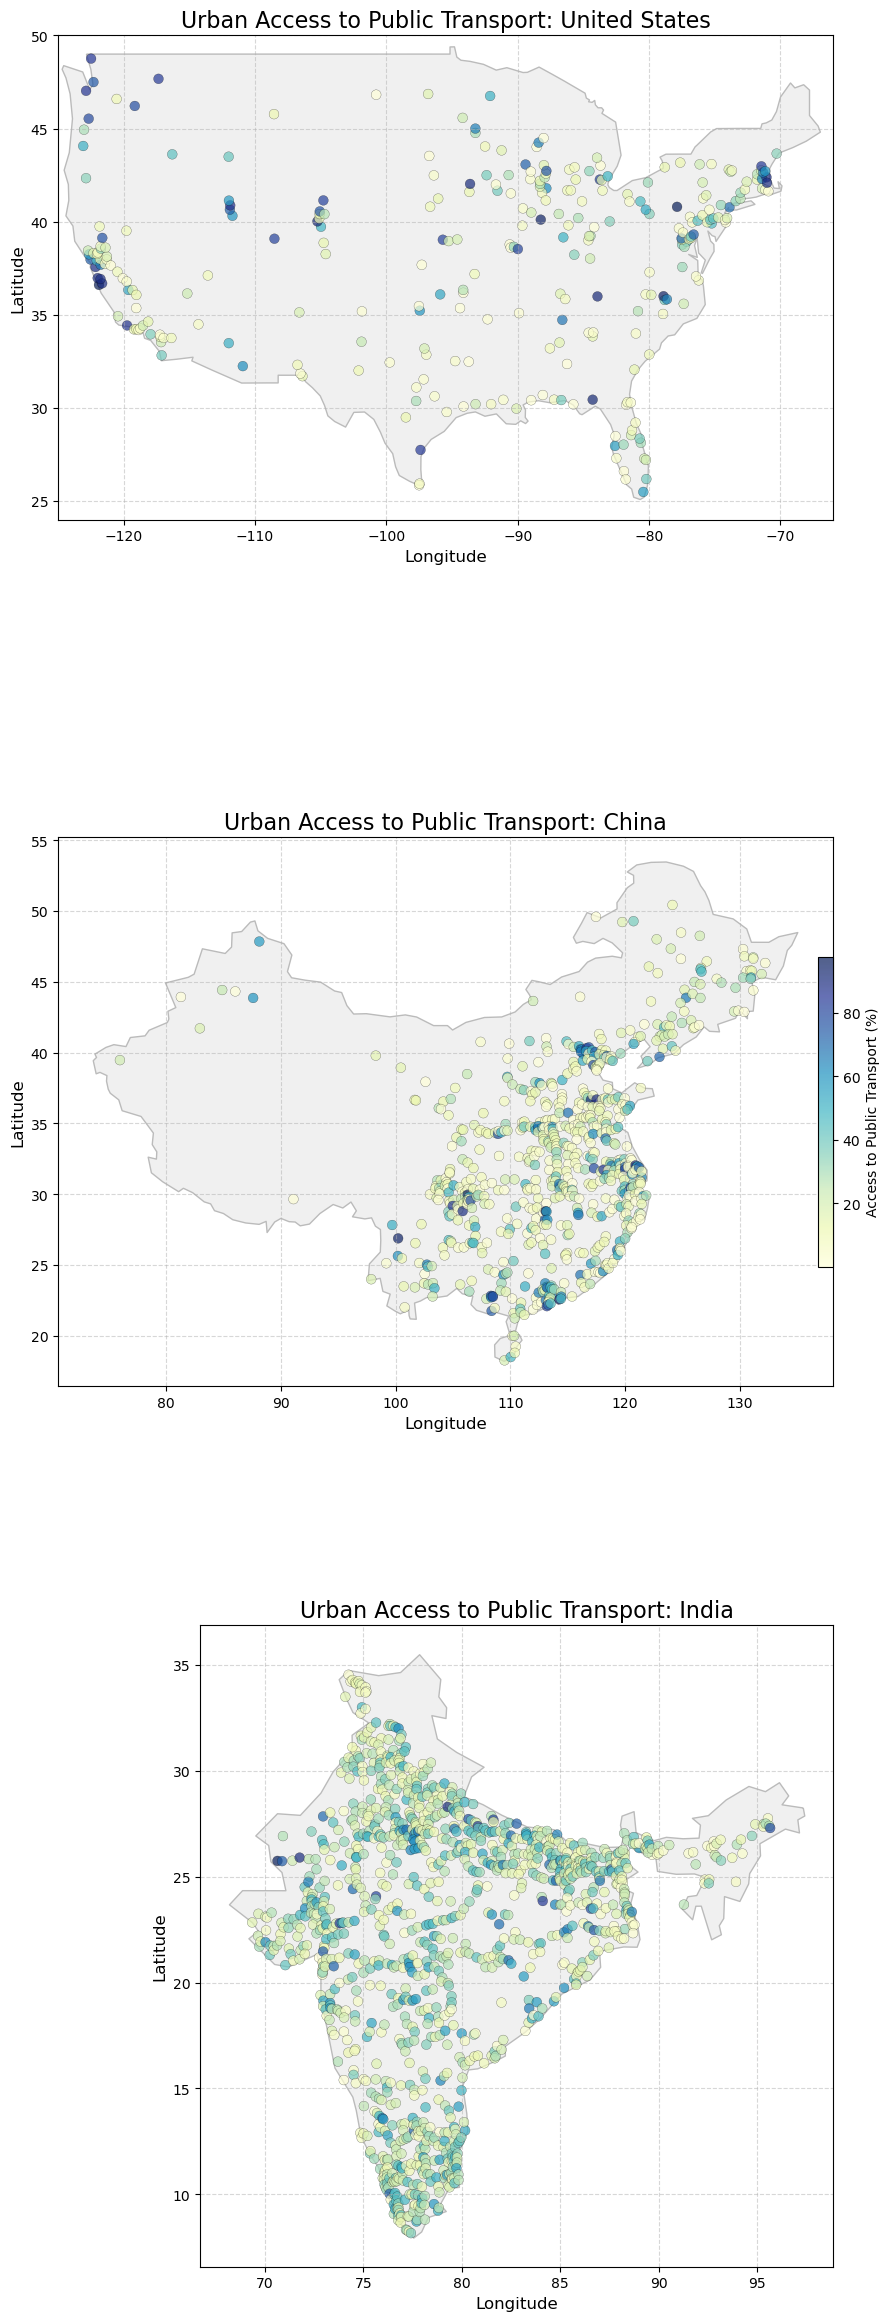

In [18]:
# Convert 'cleaned_transport_access' to a GeoDataFrame
gdf = gpd.GeoDataFrame(cleaned_transport_access, geometry=gpd.points_from_xy(cleaned_transport_access.longitude, cleaned_transport_access.latitude))

# Load a world map for context
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter world map for the US, China, and India
countries = world[world['name'].isin(['United States of America', 'India', 'China'])]

# Spatial join to keep only points within the US, China, and India
gdf = gpd.sjoin(gdf, countries, how="inner", predicate='within')

# Separate the data for each country
us_data = gdf[gdf['name'] == 'United States of America']
china_data = gdf[gdf['name'] == 'China']
india_data = gdf[gdf['name'] == 'India']

# Define bounding box for the contiguous US to exclude Alaska
bbox_contiguous_us = [-125, 24, -66, 50]

# Further filter US data to exclude Alaska
us_data = us_data.cx[bbox_contiguous_us[0]:bbox_contiguous_us[2], bbox_contiguous_us[1]:bbox_contiguous_us[3]]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

# US Map (Contiguous United States)
axs[0].set_title('Urban Access to Public Transport: United States', fontsize=16)
countries[countries['name'] == 'United States of America'].plot(ax=axs[0], color='#f0f0f0', edgecolor='#bbbbbb')
sc_us = axs[0].scatter(us_data['longitude'], us_data['latitude'], 
               c=us_data['SDG1121pct'], cmap='YlGnBu', alpha=0.7, s=50, edgecolors='k', linewidth=0.2)
axs[0].set_xlim(bbox_contiguous_us[0], bbox_contiguous_us[2])  # Limit the x-axis to exclude Alaska
axs[0].set_ylim(bbox_contiguous_us[1], bbox_contiguous_us[3])  # Limit the y-axis to exclude areas outside the contiguous US
axs[0].set_xlabel('Longitude', fontsize=12)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].tick_params(axis='both', labelsize=10)
axs[0].grid(True, linestyle='--', alpha=0.5)

# China Map
axs[1].set_title('Urban Access to Public Transport: China', fontsize=16)
countries[countries['name'] == 'China'].plot(ax=axs[1], color='#f0f0f0', edgecolor='#bbbbbb')
sc_china = axs[1].scatter(china_data['longitude'], china_data['latitude'], 
                    c=china_data['SDG1121pct'], cmap='YlGnBu', alpha=0.7, s=50, edgecolors='k', linewidth=0.2)
axs[1].set_xlabel('Longitude', fontsize=12)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].grid(True, linestyle='--', alpha=0.5)

# India Map
axs[2].set_title('Urban Access to Public Transport: India', fontsize=16)
countries[countries['name'] == 'India'].plot(ax=axs[2], color='#f0f0f0', edgecolor='#bbbbbb')
sc_india = axs[2].scatter(india_data['longitude'], india_data['latitude'], 
                    c=india_data['SDG1121pct'], cmap='YlGnBu', alpha=0.7, s=50, edgecolors='k', linewidth=0.2)
axs[2].set_xlabel('Longitude', fontsize=12)
axs[2].set_ylabel('Latitude', fontsize=12)
axs[2].tick_params(axis='both', labelsize=10)
axs[2].grid(True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(sc_china, ax=axs.ravel().tolist(), label='Access to Public Transport (%)', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=10)

plt.subplots_adjust(hspace=0.3)
plt.show()

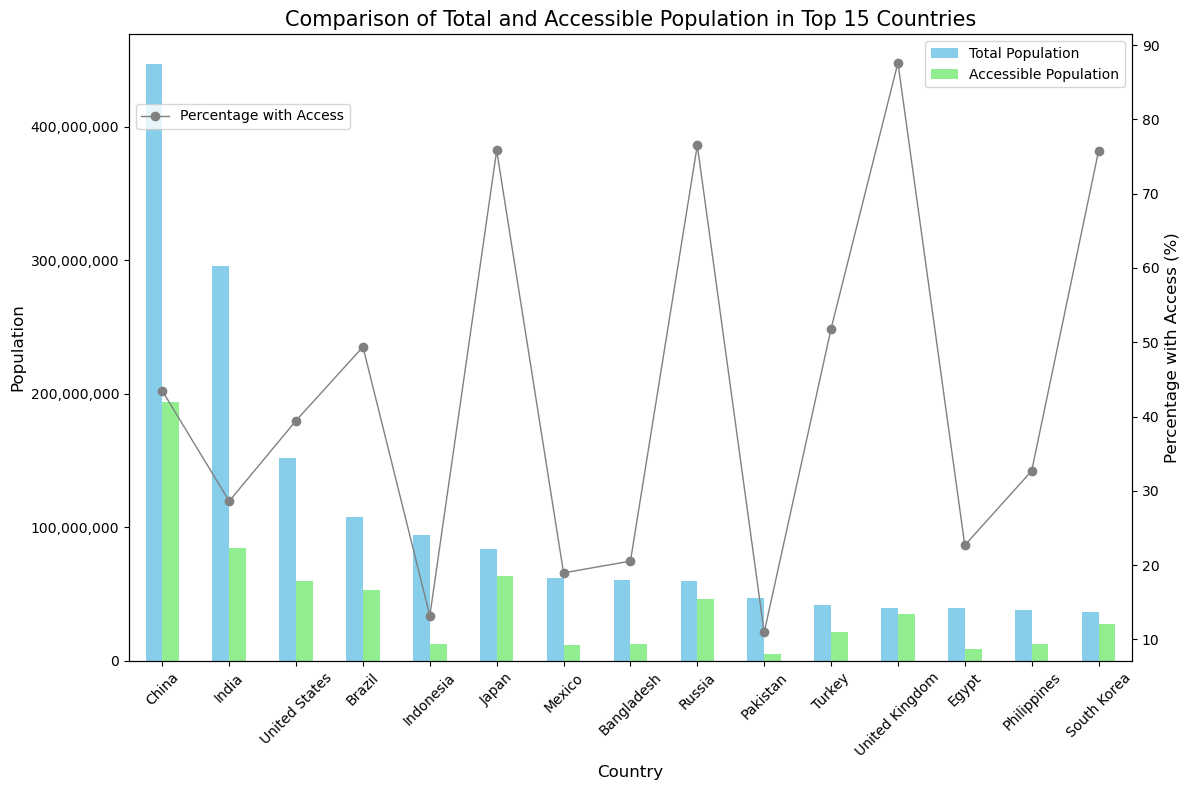

,Total Population,Accessible Population,Percentage with Access
CTR_MN_NM,,,
China,446683983.81,194074034.29,43.45
India,295276454.65,84473930.18,28.61
United States,152107308.14,60018263.81,39.46
Brazil,107683297.54,53171350.82,49.38
Indonesia,94178410.73,12409290.64,13.18
Japan,83858630.79,63577548.03,75.82
Mexico,61810163.48,11714283.13,18.95
Bangladesh,60424132.05,12406037.75,20.53
Russia,60104851.29,45985936.04,76.51


In [19]:
# Excluding urban centers that don't have any data about the Access to Public Transport
filtered_transport_access = cleaned_transport_access[cleaned_transport_access['Access_POP'].notnull()]

# Calculating total population and total accessible population for each country
total_population = filtered_transport_access['Total_POP'].groupby(filtered_transport_access['CTR_MN_NM']).sum()
population_access_to_transport = filtered_transport_access['Access_POP'].groupby(filtered_transport_access['CTR_MN_NM']).sum()

# Combining the two series into a DataFrame for easier plotting
population_comparison = pd.DataFrame({'Total Population': total_population, 'Accessible Population': population_access_to_transport})

# Calculating the percentage of population with access to public transport
population_comparison['Percentage with Access'] = (population_comparison['Accessible Population'] / population_comparison['Total Population']) * 100

# Sorting the countries based on total population and selecting the top 15
top_15_countries_population = population_comparison.sort_values(by='Total Population', ascending=False).head(15)

# Setting up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()  # instantiate a second y-axis sharing the same x-axis

# Bar chart for populations
top_15_countries_population[['Total Population', 'Accessible Population']].plot(kind='bar', ax=ax1, color=['skyblue', 'lightgreen'])
ax1.set_ylabel('Population', fontsize=12)

# Line chart for percentage with access
top_15_countries_population['Percentage with Access'].plot(kind='line', ax=ax2, marker='o', color='grey', linewidth=1, label='Percentage with Access')
ax2.set_ylabel('Percentage with Access (%)', fontsize=12)

# Adding labels and title
ax1.set_title('Comparison of Total and Accessible Population in Top 15 Countries', fontsize=15)
ax1.set_xlabel('Country', fontsize=12)

# Formatting the y-axis to include commas
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Adding legend for the line plot
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

# Showing the plot
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

top_15_countries_population
